In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight


In [4]:
data = pd.read_parquet('data/train.parquet', engine='pyarrow')
data

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
...,...,...,...,...
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


In [6]:
data.isnull().sum()

id        0
dates     0
values    0
label     0
dtype: int64

<Axes: >

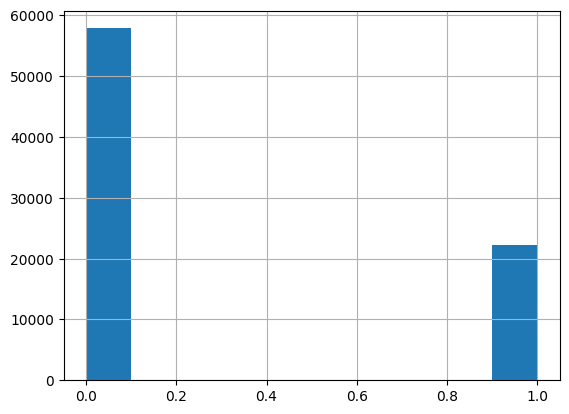

In [7]:
data.label.hist()

In [8]:
def plot(row):
    values = np.array(row['values'])
    date = np.array(row['dates'])
    plt.plot(date, values)
    plt.show()

In [9]:
# features = data.apply(plot, axis=1, result_type='expand')

In [10]:
def generate_features(row):
    values = np.array(row['values'])
    date = np.array(row['dates'])
    id = np.array(row['id'])
    return {
        'mean': np.mean(values),
        'std': np.std(values),
        'min': np.min(values),
        'max': np.max(values),
        'median': np.median(values),
        'skew' : skew(values),
        'kurtosis' : kurtosis(values),
        'date' : date,
        'id' : id
    }

In [11]:
pre_features = data.apply(generate_features, axis=1, result_type='expand')
pre_features

,mean,std,min,max,median,skew,kurtosis,date,id
0,0.023710,1.337272,-4.840000,3.49,-0.110000,-0.304166,1.889654,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...",19114
1,-0.310777,1.556337,-3.534409,2.92,-0.274409,-0.011952,-0.107257,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...",22769
2,-0.046042,1.065023,-1.950000,2.61,-0.145000,0.377148,-0.272738,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...",76935
3,-0.130000,1.158201,-2.220000,2.49,-0.345000,0.112395,-0.849629,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...",66297
4,-0.270536,1.270529,-2.500000,2.87,-0.475000,0.398655,-0.587199,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...",2191
...,...,...,...,...,...,...,...,...,...
79995,0.163818,1.303965,-3.640000,2.56,0.160000,-0.717290,0.981033,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...",71474
79996,-0.112555,1.216413,-2.590000,2.16,-0.180000,0.111317,-1.059264,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...",36908
79997,-0.201373,1.182551,-2.890000,2.27,-0.140000,-0.055628,-0.239816,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...",63517
79998,-0.075397,1.491254,-2.850000,3.11,0.240000,-0.142759,-0.978812,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...",94731


In [12]:
pre_features['label'] = data['label']
pre_features_without_date = pre_features.drop(['date'], axis=1)

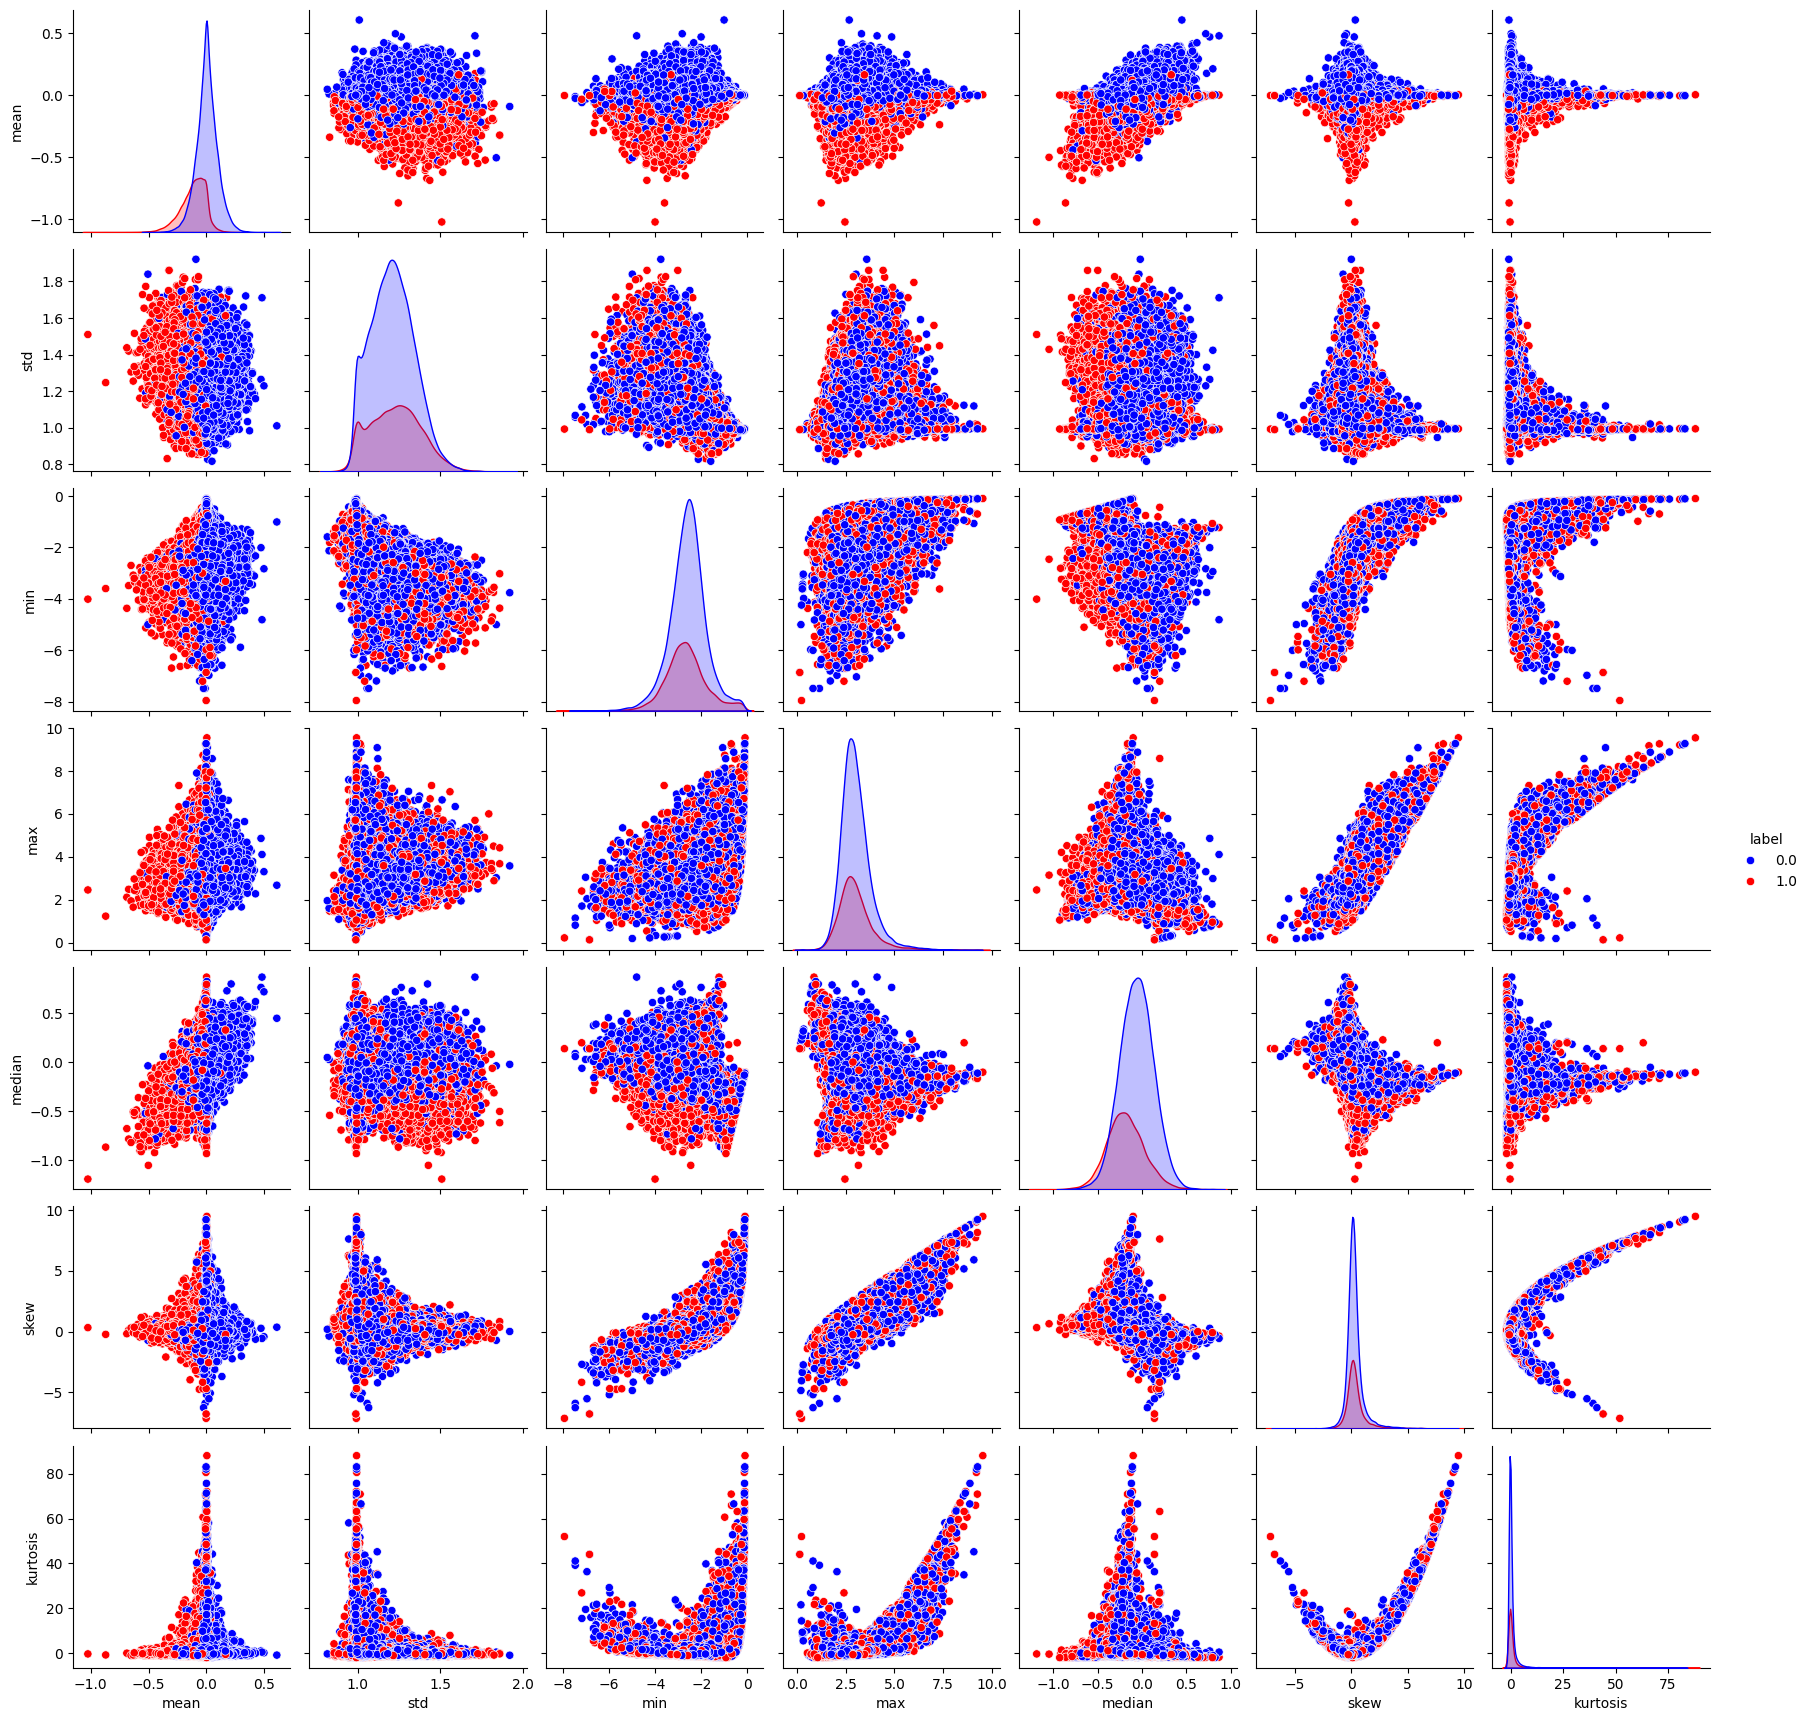

In [13]:
sns.pairplot(pre_features_without_date, hue='label', palette={1 : 'red', 0 : 'blue'})

(<Axes: >, <Axes: >)

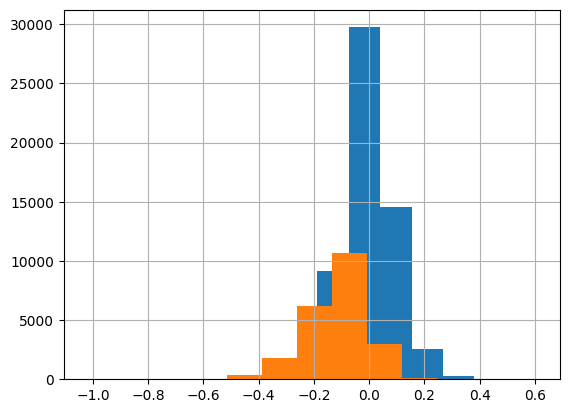

In [14]:

pre_features_without_date.query('label == 0')['mean'].hist(), pre_features_without_date.query('label == 1')['mean'].hist()

(<Axes: >, <Axes: >)

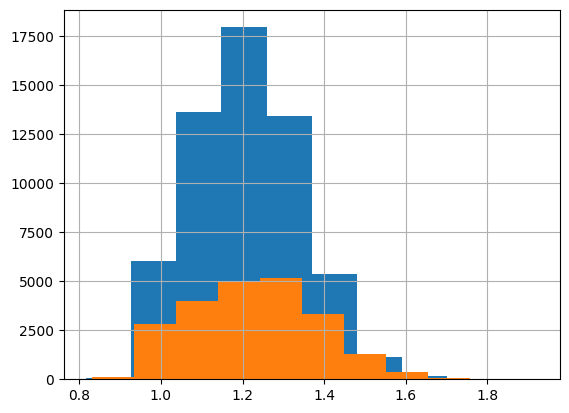

In [15]:
pre_features_without_date.query('label == 0')['std'].hist(), pre_features_without_date.query('label == 1')['std'].hist()

#Существует разница в статистических характеристиках(гипотеза)


(<Axes: >, <Axes: >)

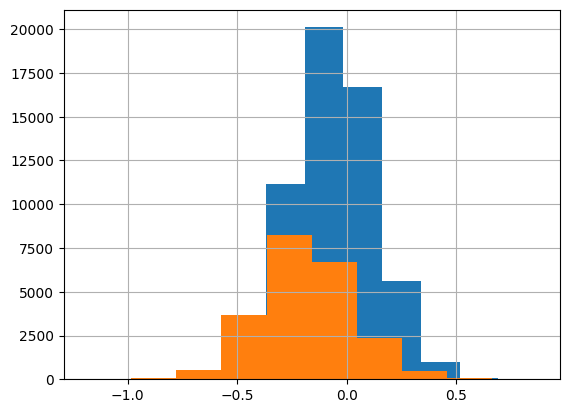

In [16]:
pre_features_without_date.query('label == 0')['median'].hist(), pre_features_without_date.query('label == 1')['median'].hist()

(<Axes: >, <Axes: >)

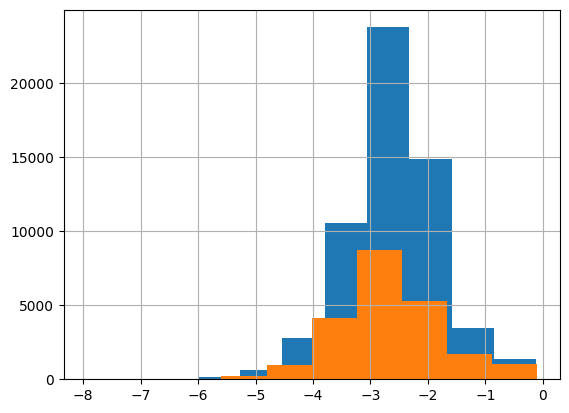

In [17]:
pre_features_without_date.query('label == 0')['min'].hist(), pre_features_without_date.query('label == 1')['min'].hist()

(<Axes: >, <Axes: >)

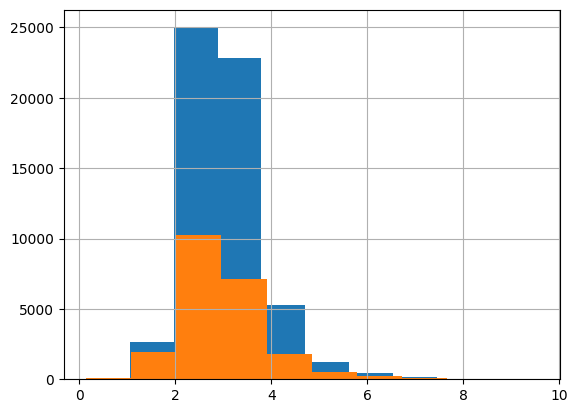

In [18]:
pre_features_without_date.query('label == 0')['max'].hist(), pre_features_without_date.query('label == 1')['max'].hist()

(<Axes: >, <Axes: >)

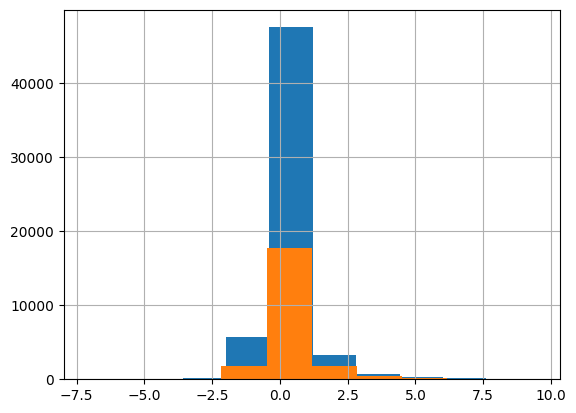

In [19]:
pre_features_without_date.query('label == 0')['skew'].hist(), pre_features_without_date.query('label == 1')['skew'].hist()

(<Axes: >, <Axes: >)

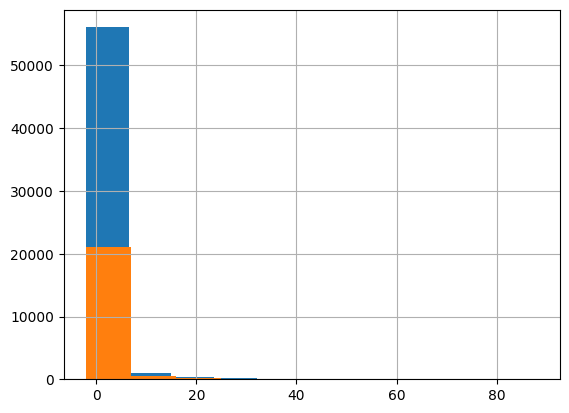

In [20]:
pre_features_without_date.query('label == 0')['kurtosis'].hist(), pre_features_without_date.query('label == 1')['kurtosis'].hist()

In [21]:
plot_data = data.sample(9)

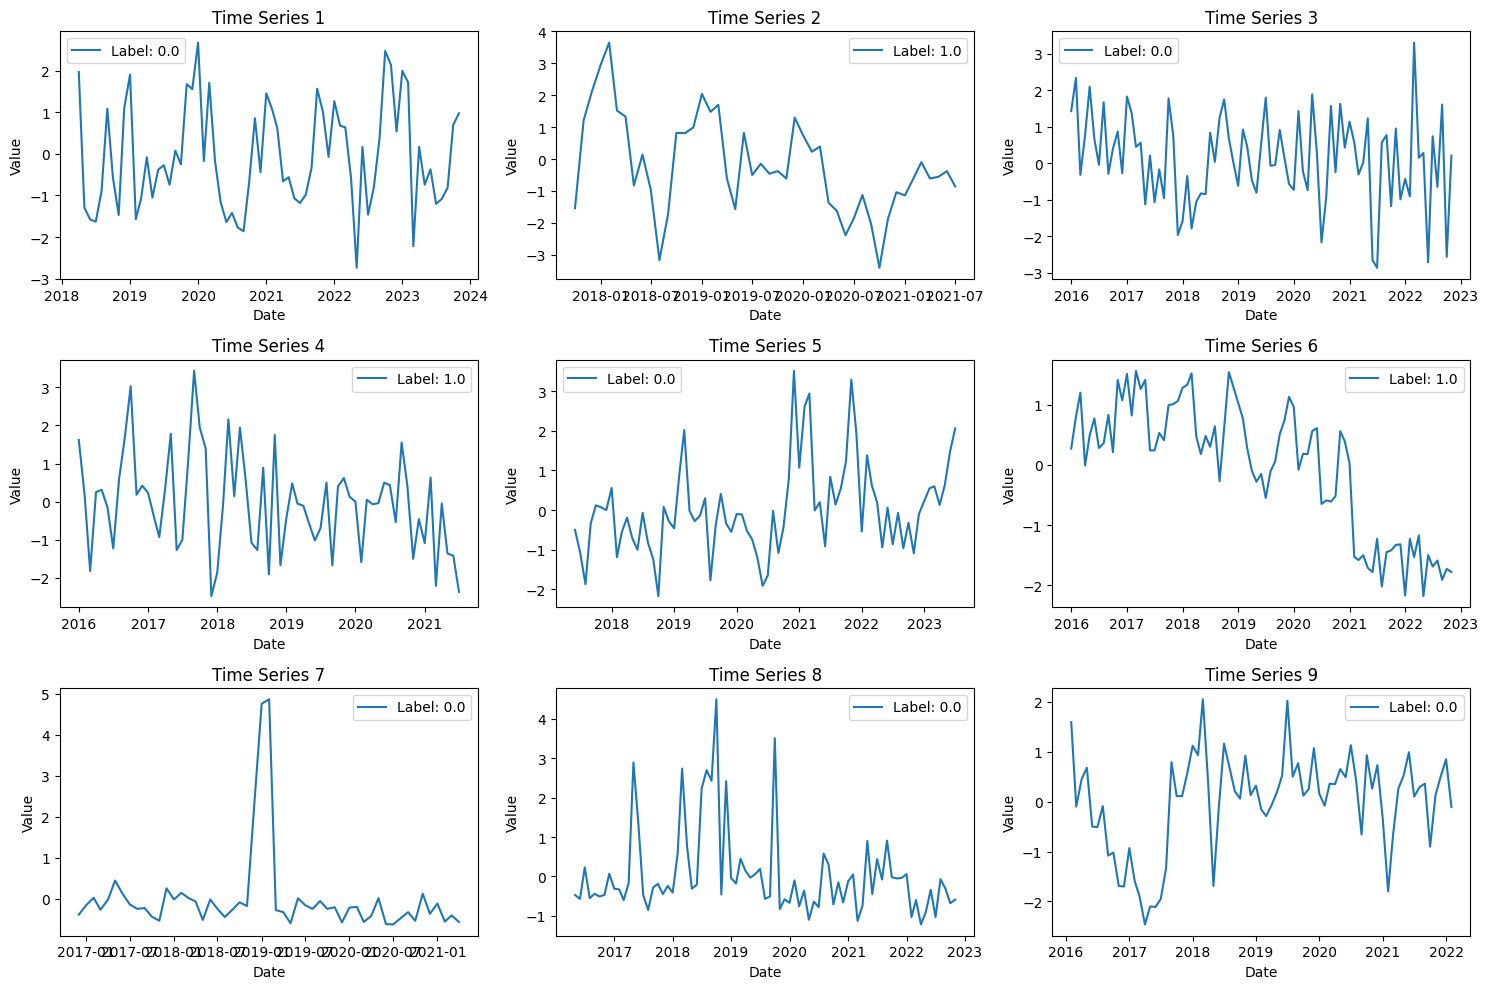

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# Проход по подграфикам и построение графиков
for i, ax in enumerate(axes.flatten()):
    if i < len(plot_data):
        row = plot_data.iloc[i]
        dates = pd.to_datetime(row['dates'])
        values = row['values']
        label = row['label']
        
        ax.plot(dates, values, label=f'Label: {label}')
        ax.set_title(f'Time Series {i+1}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Value')
        ax.legend()
    else:
        # Если данных меньше, чем подграфиков, скрываем лишние подграфики
        ax.axis('off')

# Улучшение расположения подграфиков
plt.tight_layout()

In [23]:
pre_features_without_date.isna().sum()

mean        88
std         88
min         88
max         88
median      88
skew        88
kurtosis    88
id           0
label        0
dtype: int64

In [24]:
for col in pre_features_without_date.columns:
    pre_features_without_date.fillna(pre_features_without_date[col].mean(), inplace=True)

In [25]:
scaler = MinMaxScaler()
scaled_pre_features_without_date_array = scaler.fit_transform(pre_features_without_date)
scaled_pre_features_without_date_data = pd.DataFrame(data = scaled_pre_features_without_date_array, columns=pre_features_without_date.columns)
scaled_pre_features_without_date_data

,mean,std,min,max,median,skew,kurtosis,id,label
0,0.642090,0.700924,0.392775,0.367947,0.524288,0.411292,0.043035,0.191142,0.0
1,0.437169,0.813064,0.557664,0.308398,0.444480,0.428861,0.020846,0.227692,1.0
2,0.599357,0.561559,0.757765,0.276012,0.507298,0.452255,0.019007,0.769358,0.0
3,0.547921,0.609257,0.723666,0.263475,0.410214,0.436337,0.012597,0.662977,0.0
4,0.461822,0.666758,0.688303,0.303174,0.347109,0.453548,0.015513,0.021910,0.0
...,...,...,...,...,...,...,...,...,...
79995,0.727926,0.683874,0.544328,0.270788,0.655351,0.386453,0.032939,0.714747,0.0
79996,0.558608,0.639056,0.676937,0.229000,0.490308,0.436272,0.010268,0.369084,1.0
79997,0.504195,0.621722,0.639049,0.240492,0.509725,0.426235,0.019373,0.635176,0.0
79998,0.581373,0.779748,0.644100,0.328248,0.694185,0.420996,0.011161,0.947319,0.0


In [26]:
X = scaled_pre_features_without_date_data.drop(['label', 'min', 'max', 'skew', 'kurtosis', 'id'], axis=1)
y = scaled_pre_features_without_date_data.label

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [42]:

clf = RandomForestClassifier(random_state=42)

In [43]:
param = {'n_estimators' : range(1, 100, 10), 'ma9x_depth': range(1, 100, 10), 'min_samples_leaf' : range(1, 40, 5), 'min_samples_split' : range(2, 30, 5), 'class_weight': ['balanced']}
grid_clf = GridSearchCV(clf, param, scoring='roc_auc', n_jobs=-1, cv=5)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': range(1, 100, 10),
                         'min_samples_leaf': range(1, 40, 5),
                         'min_samples_split': range(2, 30, 5),
                         'n_estimators': range(1, 100, 10)},
             scoring='roc_auc')

In [44]:
grid_clf.best_params_

{'class_weight': 'balanced',
 'max_depth': 11,
 'min_samples_leaf': 21,
 'min_samples_split': 2,
 'n_estimators': 91}

In [45]:
best_clf = grid_clf.best_estimator_
y_pred = grid_clf.predict(X_test)
roc_auc_score(y_test, y_pred)

0.7394392577856795

In [30]:
cat_clf = CatBoostClassifier(iterations=1000, learning_rate=0.1)
cat_clf.fit(X_train, y_train)


0:	learn: 0.6400211	total: 150ms	remaining: 2m 30s
1:	learn: 0.5982791	total: 163ms	remaining: 1m 21s
2:	learn: 0.5659752	total: 176ms	remaining: 58.4s
3:	learn: 0.5444995	total: 187ms	remaining: 46.5s
4:	learn: 0.5243564	total: 199ms	remaining: 39.7s
5:	learn: 0.5084240	total: 211ms	remaining: 35s
6:	learn: 0.4969380	total: 221ms	remaining: 31.4s
7:	learn: 0.4880157	total: 232ms	remaining: 28.8s
8:	learn: 0.4809948	total: 245ms	remaining: 26.9s
9:	learn: 0.4761654	total: 257ms	remaining: 25.5s
10:	learn: 0.4715030	total: 268ms	remaining: 24.1s
11:	learn: 0.4671713	total: 279ms	remaining: 23s
12:	learn: 0.4633336	total: 291ms	remaining: 22.1s
13:	learn: 0.4603370	total: 303ms	remaining: 21.3s
14:	learn: 0.4584823	total: 314ms	remaining: 20.6s
15:	learn: 0.4566201	total: 326ms	remaining: 20.1s
16:	learn: 0.4548526	total: 338ms	remaining: 19.6s
17:	learn: 0.4531427	total: 349ms	remaining: 19s
18:	learn: 0.4519873	total: 360ms	remaining: 18.6s
19:	learn: 0.4508666	total: 374ms	remaining: 

In [31]:
y_pred = cat_clf.predict(X_test)
roc_auc_score(y_test, y_pred)

0.6934721826960455

In [27]:
test = pd.read_parquet('data/test.parquet', engine='pyarrow')


In [28]:
features_test = test.apply(generate_features, axis=1, result_type='expand')

In [29]:
features_test

,mean,std,min,max,median,skew,kurtosis,date,id
0,0.037895,1.505985,-3.140000,3.13,-0.010,0.066034,-0.416815,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...",6125
1,-0.016909,1.249663,-2.240000,3.85,-0.080,0.874569,0.857138,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...",26781
2,-0.039569,1.000514,-1.450000,3.46,-0.160,0.963947,1.074141,"[2016-06-01, 2016-07-01, 2016-08-01, 2016-09-0...",13333
3,0.159231,1.313112,-2.730000,3.43,0.110,0.384563,-0.054884,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...",53218
4,-0.094705,1.243279,-2.660000,2.57,-0.090,-0.032288,-0.534065,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...",84204
...,...,...,...,...,...,...,...,...,...
19995,-0.022217,1.077283,-1.550000,3.86,-0.275,1.511330,2.713467,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...",80341
19996,0.072439,1.381959,-3.000000,2.78,0.260,-0.276615,-0.638944,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...",5891
19997,0.068727,1.173802,-3.660000,1.91,0.290,-1.238295,1.490626,"[2017-01-01, 2017-02-01, 2017-03-01, 2017-04-0...",29091
19998,-0.037175,1.177763,-2.801675,2.40,-0.180,0.118480,-0.641838,"[2017-04-01, 2017-05-01, 2017-06-01, 2017-07-0...",85877


In [36]:
y = [1, 3, 4, 4, 5]
np.unique(y)

array([1, 3, 4, 5])

In [33]:
np.unique(y)

array([1, 3, 4])